# Table of Contents
1. [Project Overview](#1-project-overview)
2. [Data Quality & EDA](#2-data-quality--eda)
3. [Model Development & Validation](#3-model-development--validation)
4. [Conclusion](#4-conclusion)
5. [Potential Improvements](#5-potential-improvements)

# **1. Project Overview**
**Goal:**   Develop a model to predict a company's probability of default (PD) based on its financial ratios.

**Data:**    
*   Historical financial ratios of public companies during the 1995-2004 period, and
*   Historical default events of public companies during the 1995-2004 period.

**Features Definition:**
* WC2TA: Working capital/Total assets
* RE2TA: Retained earning/Total assets
* EBIT2TA: EBIT/Total Assets
* ME2TL: Market Equity/Total Liabilities
* S2TA: Sales/Total assets
* Default: 1 for defaut events, 0 for non-default events

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# **2. Data Quality & EDA**

Exploratory Data Analysis is presented at the end of this notebook to keep the focus on developing and validating the models. Below are initial findings about the data:


* There are 3900 rows of data for 830 companies, each of which is represented by one ID.
* There is no missing data.
* The dataset is significantly imbalanced with default events accounts for only 2% of the dataset.
* We will change the data type of "Year" and "Default" to *datetime* and *categorical*, respectively.

In [2]:
# Importing the data
comp_data = pd.read_table("/Users/hoale/Code/Predicting PD by financial ratios/comp_data.txt", sep="|")
comp_data.head()

,ID,Year,Default,WC2TA,RE2TA,EBIT2TA,ME2TL,S2TA
0,1,1999,0,0.501,0.307,0.043,0.956,0.335
1,1,2000,0,0.550,0.320,0.050,1.060,0.330
2,1,2001,0,0.450,0.230,0.030,0.800,0.250
3,1,2002,0,0.310,0.190,0.030,0.390,0.250
4,1,2003,0,0.450,0.220,0.030,0.790,0.280


In [3]:
comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       3900 non-null   int64  
 1   Year     3900 non-null   int64  
 2   Default  3900 non-null   int64  
 3   WC2TA    3900 non-null   float64
 4   RE2TA    3900 non-null   float64
 5   EBIT2TA  3900 non-null   float64
 6   ME2TL    3900 non-null   float64
 7   S2TA     3900 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 243.9 KB


In [21]:
comp_data.describe()

,ID,Year,WC2TA,RE2TA,EBIT2TA,ME2TL,S2TA
count,3900.000000,3900,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,359.037179,1999-11-02 13:40:48,0.141708,0.210107,0.051708,1.947132,0.304094
min,1.000000,1995-01-01 00:00:00,-2.240000,-3.310000,-0.590000,0.020000,0.040000
25%,187.750000,1998-01-01 00:00:00,0.030000,0.090000,0.040000,0.620000,0.170000
50%,367.000000,2000-01-01 00:00:00,0.115000,0.220000,0.050000,1.130000,0.260000
75%,524.000000,2002-01-01 00:00:00,0.240000,0.370000,0.060000,2.212500,0.370000
max,830.000000,2004-01-01 00:00:00,0.770000,1.640000,0.200000,60.610000,5.010000
std,199.858753,NaN,0.170903,0.322157,0.029288,3.021428,0.207658


In [4]:
print(comp_data['Default'].value_counts())
print('Percentage of Default (%):', len(comp_data[comp_data['Default']==1])/3900*100)

Default
0    3828
1      72
Name: count, dtype: int64
Percentage of Default (%): 1.8461538461538463


In [5]:
# Convert the features' data types
comp_data['Default'] = comp_data['Default'].astype('category')
comp_data['Year'] = pd.to_datetime(comp_data['Year'], format="%Y")

# **3. Model Development & Validation**

## *1 - Logistic Regression*

In [6]:
# Assigning the features and target
X = comp_data[['WC2TA','RE2TA','EBIT2TA','ME2TL','S2TA']]
y = comp_data[['Default']]

# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_recall_curve
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

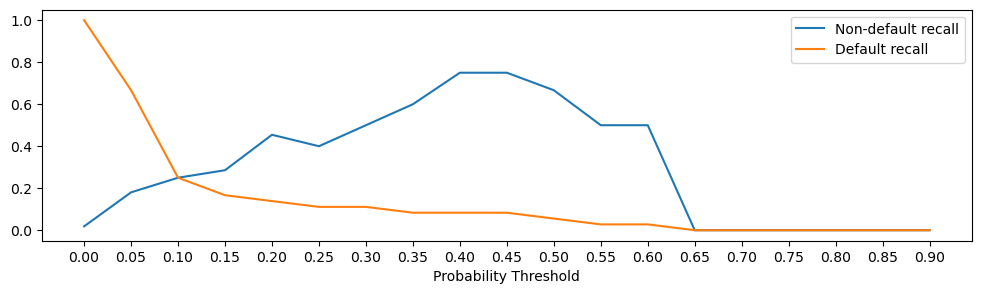

In [7]:
# Splitting the dataset to train and test subsets
random_state = 12
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = random_state, stratify = y)

# Using Logistic Regression to fit the model on the train dataset
lgr = LogisticRegression(solver='lbfgs')
lgr = lgr.fit(X_train, np.ravel(y_train))

# Predicting the probabilities of default
preds = lgr.predict_proba(X_test)
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Trying different thresholds from 0% to 90% with an increment of 5%
thresholds = np.arange(0.0, 0.95, 0.05)
default_recall = []
nondefault_recall = []

def threshold_assign(i, col_name):
    preds_df[col_name] = preds_df['prob_default'].apply(lambda x: 1 if x > i else 0)

for i in thresholds:
    col_name = "prd_" + str(i)
    threshold_assign(i, col_name)
    def_recall = precision_recall_fscore_support(y_test, preds_df[col_name])[0][1]
    default_recall.append(def_recall)
    nondef_recall = precision_recall_fscore_support(y_test, preds_df[col_name])[1][1]
    nondefault_recall.append(nondef_recall)

# Plotting the default recall and nondefault recalls
plt.figure(figsize = [12,3])
plt.plot(thresholds, default_recall)
plt.plot(thresholds, nondefault_recall)
plt.xlabel('Probability Threshold')
plt.xticks(thresholds)
plt.legend(['Non-default recall', "Default recall"])
plt.show()

* Using a test size of 0.5, the Default recall decreases significantly at the 5% and 10% thresholds, after which it continues to decrease slowly. 
* The Non-default recall peaks at the threshold of 40% - 45%, then also decreases.
* Since there is no information regarding the Loan Value, LGD, or lender's profit, we cannot calculate and use Expected Loss as a way to choose the most appropriate threshold.

## *2 - Gradient Boosted Tree*

### Baseline model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = random_state, stratify = y)

# Train a baseline GBT model with all features and make predictions
# !pip install xgboost
import xgboost as xgb
gbt = xgb.XGBClassifier()
gbt.fit(X_train, np.ravel(y_train))
gbt_preds = gbt.predict(X_test)

# Evaluate the model
print(classification_report(y_test, gbt_preds, labels=['Non-default', 'Default'],))

              precision    recall  f1-score   support

 Non-default       0.00      0.00      0.00         0
     Default       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



The classification report shows all zero scores when we fit a simple XGBoost model (without any feature engineering, model tuning, or data preprocessing).
Next, we will try to adjust the threshold to see if we can get a better model. 

### Adjust the threshold

In [9]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, gbt_preds)

# Find the optimal threshold
optimal_idx = np.argmax(precision + recall)
optimal_threshold = thresholds[optimal_idx]

# Predict with the optimal threshold
gbt_pred_proba = gbt.predict_proba(X_test)[:, 1]
gbt_pred_optimal = (gbt_pred_proba >= optimal_threshold)

# Evaluate the model
print('Optimal threshold: ', optimal_threshold)
print(classification_report(y_test, gbt_pred_optimal))

Optimal threshold:  0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1531
           1       0.02      1.00      0.04        29

    accuracy                           0.02      1560
   macro avg       0.01      0.50      0.02      1560
weighted avg       0.00      0.02      0.00      1560



A Default recall of 1 and F1 score of 0.04 suggest a low performance. Also, the optimal threshold is found at 0. All companies therefore will be predicted as *Default* even when their probability of default is just 1%. It is because the dataset is highly imbalanced. 

We will use oversampling technique to overcome the class imbalance.

### Oversampling

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1531
           1       0.30      0.45      0.36        29

    accuracy                           0.97      1560
   macro avg       0.64      0.71      0.67      1560
weighted avg       0.98      0.97      0.97      1560

AUC-ROC: 0.9238496362530688


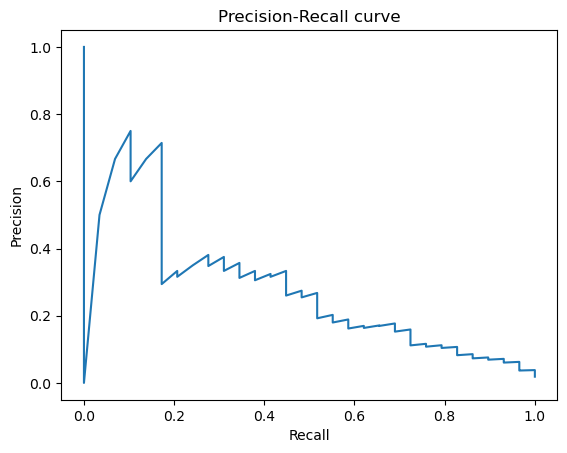

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=12)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model on the resampled dataset
rsp_gbt = xgb.XGBClassifier(enable_categorical=True)
rsp_gbt.fit(X_resampled, np.ravel(y_resampled))
rsp_gbt_preds = rsp_gbt.predict(X_test)
rsp_pred_proba = rsp_gbt.predict_proba(X_test)[:, 1]

# Classification report and AUC
from sklearn.metrics import roc_auc_score
print(classification_report(y_test, rsp_gbt_preds))
print("AUC-ROC:", roc_auc_score(y_test, rsp_pred_proba))

precision, recall, thresholds = precision_recall_curve(y_test, rsp_pred_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

Now we have a better model, demonstrated by a AUC of 0.9238, and accuracy of 0.97 as compared to 0.02 previously. We can also apply this technique to a Logistic Regression model to see if we could improve it.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train a simple logistic regression model
rsp_log_model = LogisticRegression()
rsp_log_model.fit(X_resampled, np.ravel(y_resampled))

# Predict on the test set
rsp_log_preds = rsp_log_model.predict(X_test)
rsp_log_proba = rsp_log_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, rsp_log_preds))
print("AUC-ROC:", roc_auc_score(y_test, rsp_log_proba))


              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1531
           1       0.10      0.76      0.18        29

    accuracy                           0.87      1560
   macro avg       0.55      0.81      0.55      1560
weighted avg       0.98      0.87      0.91      1560

AUC-ROC: 0.8481835176467938


Although its performance has been improved (accuracy increased from x to 0.87), the Linear Regression model is still not as good as the Gradient Boosted one. 

# **4. Conclusion**

We have developed a model to predict whether a company will default based on its financial ratios. 
- The model uses Gradient Boosting technique and is trained on a dataset of finanial ratios of 830 companies published over the period from 1995 through 2004. 
- The model has correct prediction 97% of the time including both Default and Non-default events.

# **5. Potential improvements**

A model with 97% accuracy is quite impressive. However, low precision is still a problem since the associated financial costs could be disastrous. We have some options below when looking to improve our model or develop alternatives:

- Feature engineering
- Parameter tuning
- Other modeling techniques, e.g. Random Forest, Gradient Boosting Machines, LightGBM, etc.



-------


# Exploratory Data Analysis

### WC2TA

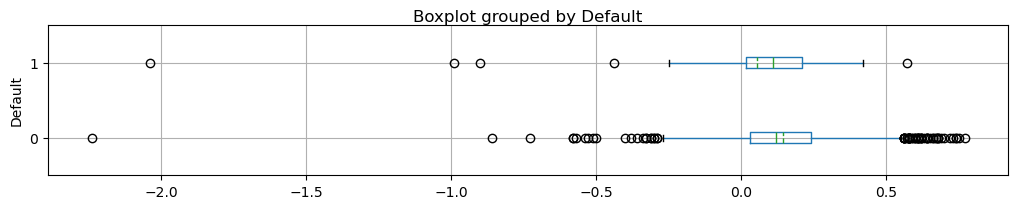

In [37]:
comp_data.boxplot('WC2TA', by='Default', grid=True, vert=False, meanline=True, showmeans=True, figsize=(12,2))
plt.title('')
plt.show()

The variance in WC2TA between default and non-default observations is not significant. \
However, default companies tends to have WC2TA closer to 0. \
Most outliers with WC2TA of less than -0.25 or higher than 0.5 are non-defaut companies.

### RE2TA

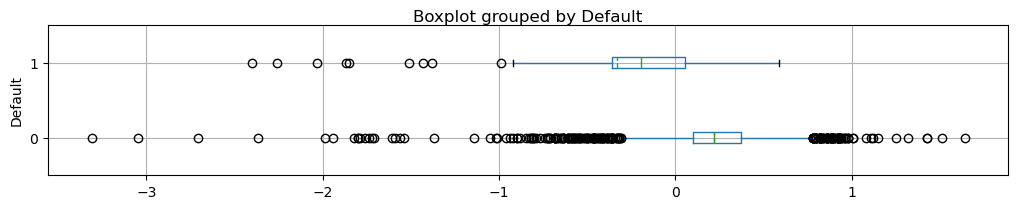

In [38]:
comp_data.boxplot('RE2TA', by='Default', grid=True, vert=False, meanline=True, showmeans=True, figsize=(12,2))
plt.title('')
plt.show()

The difference is quite clear with RE2TA. Default companies tend to have a lower RE2TA, with nearly 75% even have negative Retained Earning. Most of non-default companies have a positive RE2TA. However, non-default companies have a noticably wide range of RE2TA. There are many outliers with RE2TA lower than that of default companies.

### EBIT2TA

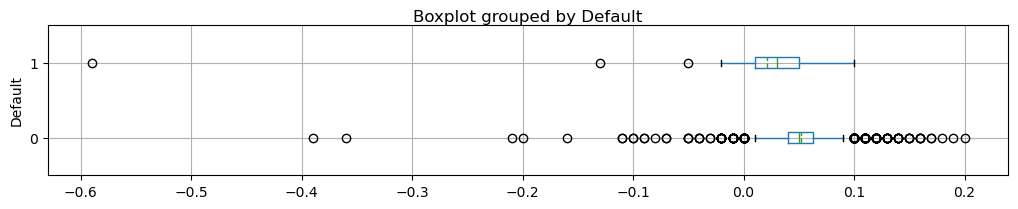

In [39]:
comp_data.boxplot('EBIT2TA', by='Default', grid=True, vert=False, meanline=True, showmeans=True, figsize=(12,2))
plt.title('')
plt.show()

The difference in EBIT2TA is not significant. We can try to have a closer look at the range -0.1 to 0.1 where there are fewer outliers.

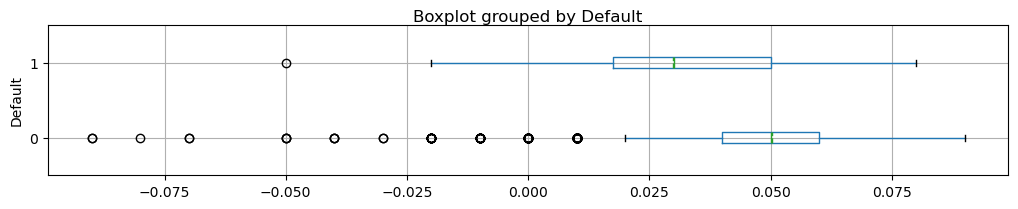

In [40]:
df_ebitta = comp_data[(comp_data['EBIT2TA'] < 0.1) & (comp_data['EBIT2TA'] > -0.1)]
df_ebitta.boxplot('EBIT2TA', by='Default', grid=True, vert=False, meanline=True, showmeans=True, figsize=(12,2))
plt.title('')
plt.show()

Now we can see that non-default companies have a slightly higher EBIT2TA on average, with 50% of those are around 4-6%. Meanwhile, 50% of default companies have EBIT2TA in the range of 2-5%. The difference is however insignificant.


### ME2TL

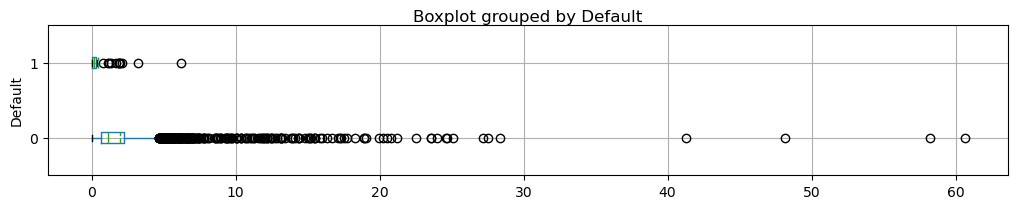

In [41]:
comp_data.boxplot('ME2TL', by='Default', grid=True, vert=False, showfliers=True, showmeans=True, meanline=True, figsize=(12,2))
plt.title('')
plt.show()

Non-default companies usually have higher ME2TL. And if we remove observations where ME2TL > 4, we will have the following boxplot.

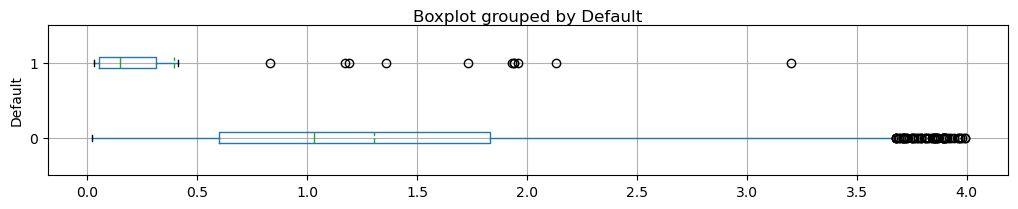

In [42]:
df1 = comp_data[comp_data['ME2TL']<4]
df1.boxplot('ME2TL', by='Default', grid=True, vert=False, showfliers=True, showmeans=True, meanline=True, figsize=(12,2))
plt.title('')
plt.show()

Now it's easier to see that default companies have much lower ME2TL. Most of them have a ME2TL of lower than 0.4, whereas more than 75% of non-default companies have a ME2TL of higher than 0.6.

### S2TA

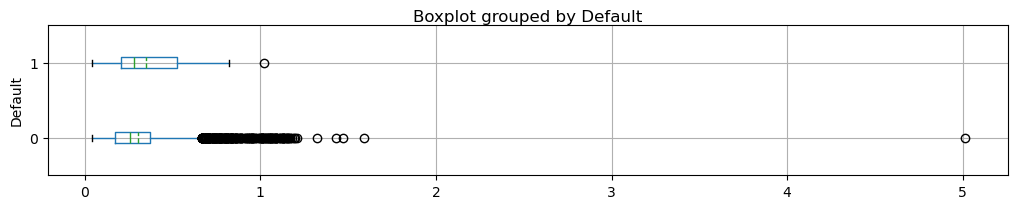

In [43]:
comp_data.boxplot('S2TA', by='Default', grid=True, vert=False, showfliers=True, showmeans=True, meanline=True, figsize=(12,2))
plt.title('')
plt.show()

Let's remove some outliers with S2TA larger than 0.8 to see if we can get a better insight.

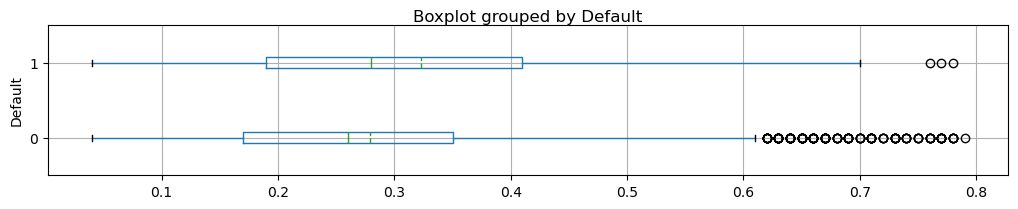

In [44]:
df_s2ta = comp_data[comp_data['S2TA'] < 0.8]
df_s2ta.boxplot('S2TA', by='Default', grid=True, vert=False, showfliers=True, showmeans=True, meanline=True, figsize=(12,2))
plt.title('')
plt.show()

Oftentimes we think that companies with higher sales are doing better, and that's only generally true if holding everything else the same. But since we are looking at Sales/Total assets, it is not sufficient to comment on the company's ability to pay off its debt.

### Correlations among features

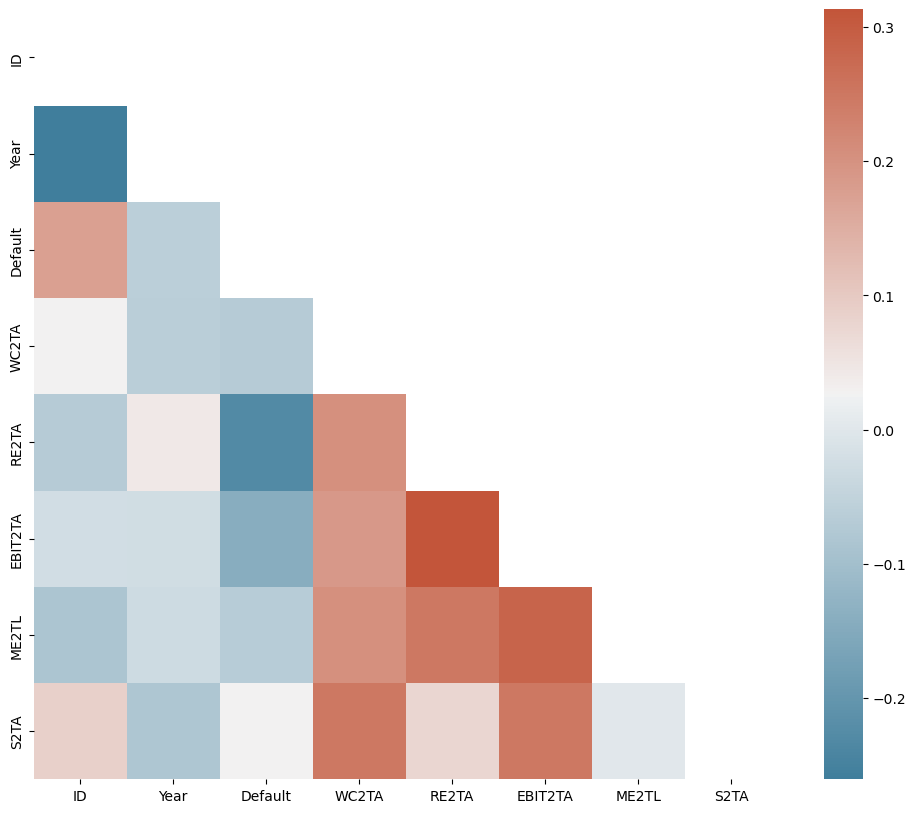

In [45]:
corr = comp_data.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap=cmap)
plt.show()

* The highest pair-wise correlation is 0.31, observed between EBIT2TA and RE2TA. 
* Surprisingly, S2TA has very low correlations with RE2TA and ME2TL.